Combining One Hot Encoding with synopsis embeddings... Why does it make sense? Combining both types of features allows the similarity calculation to consider both the detailed textual description and specific categorical attributes, leading to more accurate and relevant recommendations.

In [30]:
import ast

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

In [2]:
df = pd.read_csv('dataset/manga_dataset_with_filled_ratings_paraphrase-mpnet-base-v2.csv')
df.head()

,title,type,score,genres,themes,demographics,authors,synopsis,background,url,embeddings
0,Berserk,manga,9.47,"['Action', 'Adventure', 'Award Winning', 'Dram...","['Gore', 'Military', 'Mythology', 'Psychologic...",['Seinen'],"[{'id': 1868, 'first_name': 'Kentarou', 'last_...","Guts, a former mercenary now known as the ""Bla...",Berserk won the Award for Excellence at the si...,https://myanimelist.net/manga/2/Berserk,"0.07373989,0.080003224,0.0119243795,0.04972718..."
1,One Piece,manga,9.22,"['Action', 'Adventure', 'Fantasy']",[],['Shounen'],"[{'id': 1881, 'first_name': 'Eiichiro', 'last_...","Gol D. Roger, a man referred to as the ""King o...",One Piece is the highest selling manga series ...,https://myanimelist.net/manga/13/One_Piece,"0.120224416,0.2653468,-0.006954093,0.023620032..."
2,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,manga,9.30,"['Action', 'Adventure', 'Mystery', 'Supernatur...",['Historical'],"['Seinen', 'Shounen']","[{'id': 2619, 'first_name': 'Hirohiko', 'last_...","In the American Old West, the world's greatest...",JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,https://myanimelist.net/manga/1706/JoJo_no_Kim...,"-0.13708049,0.2916467,0.015403955,0.18725339,0..."
3,Oyasumi Punpun,manga,9.02,"['Drama', 'Slice of Life']",['Psychological'],['Seinen'],"[{'id': 2836, 'first_name': 'Inio', 'last_name...",Punpun Onodera is a normal 11-year-old boy liv...,Oyasumi Punpun was originally serialized in Yo...,https://myanimelist.net/manga/4632/Oyasumi_Punpun,"0.14025311,0.3358102,-0.0030324818,0.071511015..."
4,Fullmetal Alchemist,manga,9.03,"['Action', 'Adventure', 'Award Winning', 'Dram...",['Military'],['Shounen'],"[{'id': 1874, 'first_name': 'Hiromu', 'last_na...",Alchemists are knowledgeable and naturally tal...,Hagane no Renkinjutsushi won the 49th Shogakuk...,https://myanimelist.net/manga/25/Fullmetal_Alc...,"0.16601335,0.24077635,0.018449467,0.18147695,0..."


C:\Users\tpngu\AppData\Local\Temp\ipykernel_29752\78802940.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['score'], shade=True)


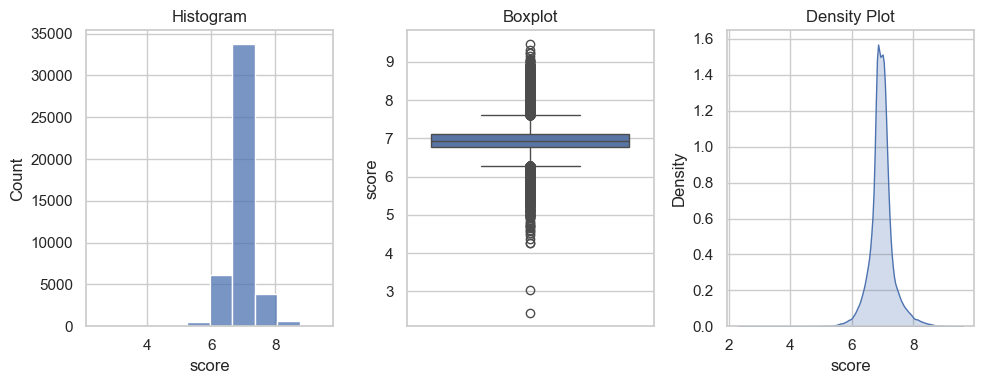

In [20]:
# Set the style for the plots
sns.set(style="whitegrid")

# Histogram
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['score'], bins=10, kde=False)
plt.title('Histogram')

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df['score'])
plt.title('Boxplot')

# Density Plot
plt.subplot(1, 3, 3)
sns.kdeplot(df['score'], shade=True)
plt.title('Density Plot')

plt.tight_layout()
plt.show()

Normalize Scores

One Hot Encode
- themes
- genres
- demographic

In [4]:
# Scale numerical features (ratings)
scaler = StandardScaler()
ratings_scaled = scaler.fit_transform(df[['score']])
ratings_scaled

array([[ 6.47408423],
       [ 5.83057676],
       [ 6.03649915],
       ...,
       [-0.01334648],
       [-0.05343558],
       [ 0.69662446]])

In [5]:
mlb = MultiLabelBinarizer()

# one hot encode the themes, genres, and demographics
genres_encoded = mlb.fit_transform(df['genres'])
themes_encoded = mlb.fit_transform(df['themes'])
demographics_encoded = mlb.fit_transform(df['demographics'])

In [19]:
print(type(genres_encoded), genres_encoded.shape, genres_encoded.dtype)
print(type(themes_encoded), themes_encoded.shape, themes_encoded.dtype)
print(type(demographics_encoded), demographics_encoded.shape, demographics_encoded.dtype)

<class 'numpy.ndarray'> (44910, 39) int32
<class 'numpy.ndarray'> (44910, 50) int32
<class 'numpy.ndarray'> (44910, 17) int32


In [26]:
# get embeddings from df convert to numpy arrays 
# synopsis_embeddings = df['embeddings'].apply(ast.literal_eval)
# synopsis_embeddings = np.array(df['embeddings'].tolist())
npz_file = np.load('synopsis_embeddings.npz')
synopsis_embeddings = npz_file['arr_0']
synopsis_embeddings.shape

(44910, 768)

In [28]:
# Combine all features into a single DataFrame
combined_features = np.hstack([
    synopsis_embeddings, # 768
    genres_encoded, # 39
    themes_encoded, # 50
    demographics_encoded # 17
])
print(combined_features.shape) # 44910, 874

(44910, 874)


In [31]:
similarity_matrix = cosine_similarity(combined_features, combined_features)

In [32]:
# Function to get recommendations based on similarity
def get_recommendations(title, similarity_matrix, df, top_n=20):
    idx = df[df['title'] == title].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:top_n+1]]
    return df['title'].iloc[sim_indices]


In [37]:
# Example usage
recommended_titles = get_recommendations('Berserk', similarity_matrix, df)
print("Recommended Manga:", recommended_titles.tolist())

Recommended Manga: ['Juu: Ninpou Makai Tensei', 'Pluto', 'Devilman', 'Elfen Lied', "Eden: It's an Endless World!"]
